# The netCDF file format

The **[netCDF](https://www.unidata.ucar.edu/software/netcdf/)** file format is a popular scientific file format for ocean and atmosphere gridded datasets. It is a collection of formats storing arrays:

* **netCDF classic**
    * more widespread
    * 2 GB file limit (if you don't use the unlimited dimension)
    * often preferred for distributing products

* **netCDF 64 bit offset**
    * supports larger files

* **NetCDF4**
    * based on [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format)
    * allows compression
    * multiple unlimited variables

netCDF was developed by Unidata-UCAR with the aim of storing climate model data, which is often 3D plus a time variable (4D total). netCDF format also allows you to store information about each variable to be added (metadata). It can have a readable text equivalent (e.g. using [ncdump](http://www.bic.mni.mcgill.ca/users/sean/Docs/netcdf/guide.txn_79.html#:~:text=The%20ncdump%20tool%20generates%20an,variable%20data%20in%20the%20file.&text=Thus%20ncdump%20and%20ncgen%20can,between%20binary%20and%20ASCII%20representations.)) and can be used with [Climate and Forecast (CF)](http://cfconventions.org/) data convention.

## Data model

|                 |                                                              |
| --------------- | -------------------------------------------------------------|
| **Dimensions**  | describe the axes of the data arrays                         |
| **Variables**   | N-dimensional arrays of data                                 |
| **Attributes**  | small note/supplementary metadata as annotations to the file |


Ocean model dataset example:
 
|   |   |   |   |   |
|---|---|---|---|---|
| **Dimensions** | lat | lon | depth | time |
| **Variable** | Temperature | Salinity |  |  |
| **Global attribute** | Geographic grid type | History |  |  |
| **Variable attributes** | Long_name: "sea water temperature" | Missing_value: 1.09009E36 | Units: deg. C | range: -2:50 |

<br>
<img src="../figures/dataset-diagram.png" style="width:600px";/>

## Python packages

The main Python interface to the netCDF C library is [netCDF4](http://unidata.github.io/netcdf4-python/) package. In this tutorial, however, we will use a more high-level package called [`xarray`](http://xarray.pydata.org/en/stable/index.html).

Note: another good package for netCDF files is [iris](http://scitools.org.uk/iris/) (developed by the UK Met Office).

# Working with netCDF files using `xarray`

[`xarray`](http://xarray.pydata.org/) package brings the power of Pandas to environmental sciences by providing N-dimensional variants of the core Pandas data structures.

| Pandas | `xarray`  |
|---|---|
| Series  | DataArray  |
| DataFrame  | Dataset  |


DataArray uses names of dimensions making it easier to track than by using axis numbers.

Compare:
```python
# xarray style
>>> ds.sel(time='2018-01-12').max(dim='ensemble')

# numpy style
>>> array[[0, 1, 2, 3], :, :].max(axis=2)
```

(Taken from Stephan Hoyer's [ECMWF talk](https://docs.google.com/presentation/d/16CMY3g_OYr6fQplUZIDqVtG-SKZqsG8Ckwoj2oOqepU/edit#slide=id.g2b68f9254d_1_27))

**Main advantages of using `xarray` versus plain netCDF4:**
* Intelligent selection along labelled dimensions (and also indexes)
* GroupBy operations
* Data alignment
* IO (netcdf)
* Conversion to and from Pandas `DataFrame` objects

In [1]:
# Import everything that we are going to need
import pandas as pd
import xarray as xr
import numpy as np

## 1. Import a local dataset

In [3]:
GETM = xr.open_dataset('../data/cefas_GETM_nwes.nc4')
print(GETM)

<xarray.Dataset>
Dimensions:     (latc: 360, lonc: 396, time: 6, level: 5)
Coordinates:
  * latc        (latc) float64 45.4 45.45 45.5 45.55 ... 63.2 63.25 63.3 63.35
  * level       (level) float64 1.0 6.0 11.0 16.0 21.0
  * lonc        (lonc) float64 -17.5 -17.42 -17.34 -17.26 ... 13.94 14.02 14.1
  * time        (time) datetime64[ns] 1996-02-01T01:00:00 ... 1996-02-06T01:0...
Data variables:
    bathymetry  (latc, lonc) float64 ...
    h           (time, level, latc, lonc) float32 ...
    temp        (time, level, latc, lonc) float32 ...
Attributes:
    title:                     North West European Shelf 3nm
    history:                   Sun Nov 20 00:54:48 2016: ncks -v time,latc,lo...
    NCO:                       4.4.8
    nco_openmp_thread_number:  1


We can see above that this file holds bathymetry, height, and temperature data for a gridded area of the North West European Shelf.

The **Dimensions**, **Coordinates**, and **Attributes** can all be access via the following methods:

**Dimensions:**
* `.dims`

**Coordinates:**
* `.coords`
    * `.latc`
    * `.level`
    * `.lonc`
    * `.time`
    
**Attributes:**
* `.attrs`
    * `.title`
    * `.history`
    * `.NCO`
    * `.nco_openmp_thread_number`

Note that the methods listed above are all specific to the netCDF file we loaded in - in other files, the Dimensions, Coordinates, and Attributes may be named differently.

We can print these dimensions to see the extent of the netCDF.

In [8]:
GETM.dims
# GETM.latc
# GETM.lonc
# GETM.time
# GETM.level

Frozen({'latc': 360, 'lonc': 396, 'time': 6, 'level': 5})

To get info on the **coordinates**:

In [15]:
print(GETM.coords['latc'])
# or 
# print(GETM.latc)

<xarray.DataArray 'latc' (latc: 360)>
array([45.400002, 45.450002, 45.500002, ..., 63.249999, 63.299999, 63.349999])
Coordinates:
  * latc     (latc) float64 45.4 45.45 45.5 45.55 45.6 ... 63.2 63.25 63.3 63.35
Attributes:
    units:    degrees_north


You can also check the **shape** of the coordinates, which may be useful as you prepare for plotting or data analysis.

In [16]:
GETM.coords['latc'].shape

(360,)

To list the dataset **attributes**:

In [7]:
GETM.attrs.keys()

dict_keys(['title', 'history', 'NCO', 'nco_openmp_thread_number'])

To list the **variable names**:

In [8]:
GETM.data_vars.keys()

KeysView(Data variables:
    bathymetry  (latc, lonc) float64 ...
    h           (time, level, latc, lonc) float32 ...
    temp        (time, level, latc, lonc) float32 ...)

This tells  us that bathymetry is 2D, varying only with latitude and longitude. Height and temperature are 4D, varying with time and model level as well.

To extract the **variable data** from the dataset:

The data associated with the variable can be accessed with the following syntax. What shape will the variable `temp` have?

In [17]:
temp = GETM['temp']
print(type( temp ))
# temp.shape

<class 'xarray.core.dataarray.DataArray'>


(6, 5, 360, 396)

Note that since `temp` is also a DataArray, we can use the same methods listed above on it.

In [28]:
temp.attrs
# temp.latc
# temp.level

{'units': 'degC',
 'long_name': 'temperature',
 'valid_range': array([-2., 40.], dtype=float32)}

## 2. Indexing and Selecting Data

### A. Access a single value

The following code extracts the **information from the indices that you specify** - i.e., it tells you what the latitude, level, longitude, and time correspond to the 0th, 0th, 90th, and 100th positions.

Note that you must specify the indices _in the order that they are written_.

In [19]:
print(temp[0, 0, 90, 100])

<xarray.DataArray 'temp' ()>
[1 values with dtype=float32]
Coordinates:
    latc     float64 49.9
    level    float64 1.0
    lonc     float64 -9.5
    time     datetime64[ns] 1996-02-01T01:00:00
Attributes:
    units:        degC
    long_name:    temperature
    valid_range:  [-2. 40.]


To get the actual **temperature value** at those indices, we use the `.values[]` method.

In [12]:
temp.values[0, 0, 90, 100]

11.532867

### B. Slicing and Dicing Data

Slicing and dicing data refer to accessing multiple values at once. This is useful because often you may just want to analyze one or two of the total dimensions you have, or a subset of certain dimensions.

<br>
<img src='https://blog.trginternational.com/hs-fs/hubfs/images/Slicing-and-Dicing.jpg?width=1422&name=Slicing-and-Dicing.jpg' style="width:600px";/>

For example, maybe you want to plot all the latitude and longitude points for a variable, but only at a single time point. That would be represented by the <span style="color:orange">orange</span> or <span style="color:red">red</span> _slices_ in the below figure.

<br>
<img src="../figures/dataset-diagram.png" style="width:600px";/>

`xarray` indexing overview can be found [here](http://xarray.pydata.org/en/stable/getting-started-guide/quick-overview.html#indexing). The graphics below is a summary what one can do:

<br>
<img src="../figures/xarray_indexing_table.png" style="width:600px";/>

Since `xarray` objects are analogous to Pandas DataFrames, we can use either **labels** _or_ **integers** (0 based indexing) to access or slice/dice data.

Note that often it is very useful to look at the **shape** of the data you are slicing or dicing to make sure you are extracting the correct parts of the data. Can you guess the shape of each slice of data below?

In [30]:
# positional by integer
print(temp[0, 2, :, :].shape)

# positional by label
print(temp.loc['1996-02-02T01:00:00', :, :, :].shape)

# by name and integer
print(temp.isel(level=1, latc=90, lonc=100).shape)

# by name and label
print(temp.sel(time='1996-02-02T01:00:00').shape)
# temp.loc

You can also **select data using the nearest value** using the `.sel()` method. This is very useful if you have multiple geospatial datasets at differing resolutions.

In [ ]:
# GETM.sel(level=1)['temp']
GETM['temp'].sel(level=2, lonc=-5.0, latc=50.0, method='nearest')

In [ ]:
# Use tolerance for label selection (lat=-50 should not yield data)
tol = 0.5

try:
    GETM['temp'].sel(level=1, lonc=-5.0, latc=-50.0, method='nearest', tolerance=tol)
except KeyError:
    print(f'ERROR: outside tolerance of {tol}')

## 3. Plotting

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

The following code defines a general mapping function using `cartopy`. It just adds the desired map features without plotting any data yet:
* Creates the figure, axis, and subplot
* Adds the coastlines
* Specifies the desired projection
* Specifies map extent
* Specifies colors and scale

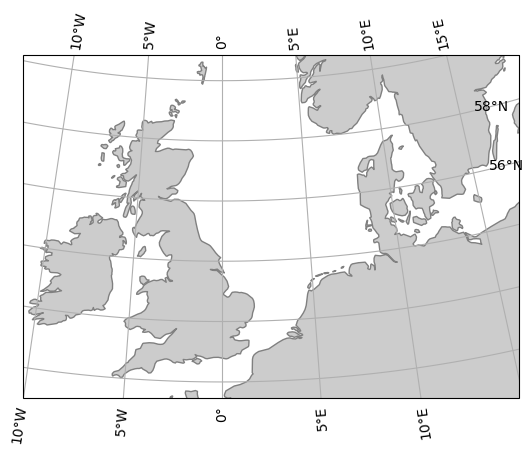

In [39]:
def make_map():
    # create figure and axes instances
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=ccrs.Stereographic(central_latitude=60))
    #ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_extent([-10, 15, 49, 60], crs=ccrs.PlateCarree())
    
    gl = ax.gridlines(draw_labels=True)
    
    feature = cartopy.feature.NaturalEarthFeature(name='coastline',
                                                  category='physical',
                                                  scale='50m',
                                                  edgecolor='0.5',
                                                  facecolor='0.8')
    ax.add_feature(feature)
    return fig, ax

make_map()
plt.show()

The following code now actually adds our data to the map we created in the function `make_map()` above.

In [42]:
# Slice the data we wish to plot
var = GETM.temp.sel(time='1996-02-02T01:00:00',level=21) # What dimensions and shape does our slice have?

# Extract the latitude and longitude values
latc = GETM.coords['latc']
lonc = GETM.coords['lonc']

# Create the map figure with our desired features using the function we defined above
fig, ax = make_map()

# Actually plot our sliced netCDF data onto the map we made
h = ax.contourf(lonc, latc, var, 50, cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(h)
cbar.set_label(var.units)

# Add a title
ax.set_title(f'A slice of {var.long_name}');

Note that you can also use the built-in `xarray` plotting method `.plot()` as a quick way to visualize your data. However, adding the different map specifications (e.g., projection, coastlines) will be more difficult without going the "long way" as detailed above.

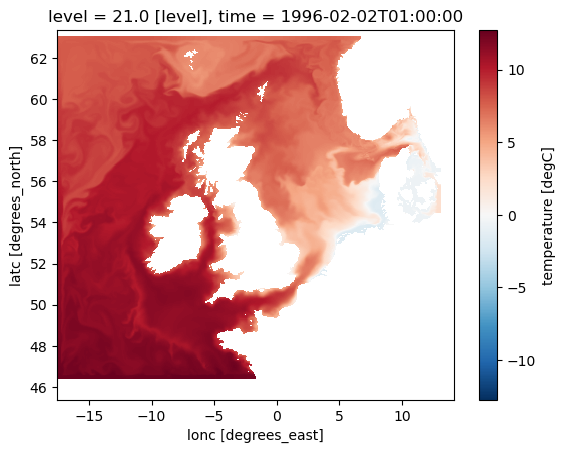

In [45]:
# But often, this will do
# GETM.temp.isel(time=0, level=0).plot();
GETM.temp.sel(time='1996-02-02T01:00:00', level=21).plot()
plt.show()

## 3. Mathematical operations

You can also easily perform mathematical operations on `xarray Datasets`.

**A. Arithmetic operations**

In the example below, we will find the **temperature difference** between the **highest and lowest depth layers** in our dataset.

In [49]:
# Slice the data from the top and bottom layers...what shape will these slices have?
top = GETM['temp'].isel(time=0, level=4)
bottom = GETM['temp'].isel(time=0, level=0)

# Calculate the difference between the two layers
diff = top - bottom

# Plot the data
diff.plot()
plt.show()

When performing mathematical operations on Datasets (or any data structure, really), **what must be true about the <u>shape</u> of the two Datasets?**

**B. Calculations along a dimension**
In the example below, we will calculate the **average temperature** over the **time** and **level** dimensions.

**i.** <u>Average temperature over all time points</u>

* What shape will `time_ave` have? Why does it have this shape?
* Plot `time_ave`. Why does the plot look the way it does? What dimensions do you think are being plotted?

In [61]:
# Calculate average temperature over all time
time_ave = GETM['temp'].mean('time')

time_ave.plot()
plt.show()

**ii.** <u>Average temperature over all time points and all vertical levels</u>
* What shape will `time_and_level_ave` have? Why does it have this shape?
* Plot `time_and_level_ave`. What dimensions are being plotted?

In [55]:
# Calculate average temperature over time and all levels
time_and_level_ave = GETM['temp'].mean(['time','level'])

time_and_level_ave.plot()
plt.show()

**iii.** <u>Average temperature over all time points and all longitude points</u>
* What shape will `timelon_ave` have? Why does it have this shape?
* Plot `timelon_ave`. Why isn't the plot a map? What dimensions are being plotted?

In [66]:
# Calculate zonal average for single vertical layer
timelon_ave = GETM['temp'].mean(['time','lonc']).isel(level=4)

timelon_ave.plot()
plt.show()

## 4. Saving Datasets to a netCDF file

`xarray Datasets` can easily be saved as new netCDF files.

In the example below, we will save the temperature averages we calculate into a new netCDF file.

In [69]:
# Calculate the average temperature across all time points and all vertical levels
ds = GETM['temp'].mean(['time','level']) # what shape will ds have?

# Save data slice as its own netCDF file
ds.to_netcdf('../data/temp_avg_level_time.nc')

## 5. Import remote dataset

`xarray` supports [OpenDAP](https://www.opendap.org/). This means that a dataset can be accessed remotely and subsetted as needed. Only the selected parts are downloaded.

In [ ]:
remote_data = xr.open_dataset(
      'http://iridl.ldeo.columbia.edu/SOURCES/.OSU/.PRISM/.monthly/dods',
      decode_times=False)
remote_data

***
***

# Exercises

## Exercise 1

* Using the netCDF we have already loaded into this notebook, extract the bathymetry data.
    * You can reuse the variable `GETM` that we already defined above.
* Extract the time averaged seabed temperature at level = 0
* Produce a plot of the time average seabed temperature at level = 0

In [ ]:
GETM.data_vars.keys()

In [ ]:
# Extract the bathymetry data from GETM

# Calculate the average temperature over all time points at level = 0

# Plot the average temperature at level = 0 against depth

## Excercise 2
Import data from a netCDF or csv file and start exploring it. Some ideas:
- Use pandas to get quick statistics
- Do some data cleaning and calculations with numpy
- Plot it up with matplotlib, pandas, seaborn or cartopy as you prefer

I encourage you to use your own data if you have some. If not, we have some sample datasets you can explore.

### Earthquake data (csv file)
US Geological Survey (USGS) provides various [earthquakes data](https://earthquake.usgs.gov/data/data.php#eq) on a global scale. Its Earthquake Catalog contains earthquake source parameters (e.g. hypocenters, magnitudes, phase picks and amplitudes) and other products (e.g. moment tensor solutions, macroseismic information, tectonic summaries, maps) produced by contributing seismic networks.

If you follow this [link](http://earthquake.usgs.gov/earthquakes/search/), you can search throught the catalog and filter data by the magnitude, time and geographic region. In the `data/` folder, we provide an [example dataset](../data/earthquakes_2015_2016_gt45.csv) of earthquakes with magnitude >4.5 that occurred around the world over the period of a year.

To get you started, the following cell loads the data into a pandas DataFrame

In [ ]:
# import pandas as pd
# df = pd.read_csv('../data/earthquakes_2015_2016_gt45.csv', parse_dates = ['time',], index_col='time')
# df.head()

If you want to build your project on these data, some possible ideas are:
* `pandas` package will be most useful to read in the data, as well as analyse them
* Use `cartopy` to plot the data using longitude and latitude columns
* Explore `pandas`' `groupby()` method, which you can use to aggregate data by time or other parameter
* Create a histogram of earthquakes magnitude

### Arctic Sea Ice (netCDF files)
* In this project you are offered to use NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration.
* In the `../data/` directory, there are 2 netCDF files `seaice_conc_monthly*` that correspond to September 1991  and September 2012 .
* If you want to download data for other months, visit the [NSIDC's data portal](https://nsidc.org/data/search/#keywords=sea+ice/sortKeys=score,,desc/facetFilters=%257B%257D/pageNumber=1/itemsPerPage=25).

For this project, I recommend that you:
* use `xarray` for opening and reading the netCDF files
* use `cartopy` for creating a plot with a correct map projection
* use appropriate colormaps for the sea ice concentration and difference between the two years

Some code to get you started:

In [ ]:
# import cartopy.crs as ccrs
# import matplotlib.pyplot as plt
# import xarray as xr

In [ ]:
# ds1 = xr.open_dataset('../data/seaice_conc_monthly_nh_f08_199109_v02r00.nc')
# ds2 = xr.open_dataset('../data/seaice_conc_monthly_nh_f17_201209_v02r00.nc')

## References

* https://www.unidata.ucar.edu/software/netcdf/docs/netcdf_data_model.html
* http://xarray.pydata.org/en/stable/getting-started-guide/quick-overview.html#indexing